In [1]:
import sys
!{sys.executable} -m pip install --user -q statsmodels scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

YEARS = list(range(2014, 2020))

PROCESSED_DIR = Path("data/processed")

PATH_COUNTS = PROCESSED_DIR / "county_plan_counts_2014_2019.csv"
PATH_HHI    = PROCESSED_DIR / "county_hhi_ma_share_2014_2019.csv"

PATH_BIDS_2014 = PROCESSED_DIR / "plan_bids_pmpm_2014.csv"
PATH_BIDS_2018 = PROCESSED_DIR / "plan_bids_pmpm_2018.csv"

PATH_COUNTY_BID_HHI_2018 = PROCESSED_DIR / "county_bid_hhi_2018.csv"
PATH_FFS_2018_Q          = PROCESSED_DIR / "ffs_cost_2018_with_quartiles.csv"

def require_file(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p}. Run your build notebooks first.")

for p in [PATH_COUNTS, PATH_HHI, PATH_BIDS_2014, PATH_BIDS_2018, PATH_COUNTY_BID_HHI_2018, PATH_FFS_2018_Q]:
    require_file(p)

print("All required files found.")

All required files found.


In [2]:
from scipy.spatial.distance import cdist

def weighted_mean(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    w_sum = np.sum(w)
    if w_sum <= 0:
        return np.nan
    return np.sum(w * x) / w_sum

def make_quartile_dummies(df, quartile_col="ffs_quartile"):
    d = df.copy()
    for q in [1, 2, 3, 4]:
        d[f"ffs_q{q}"] = (d[quartile_col] == q).astype(int)
    return d

def _fit_logit_safe(y, X):
    """
    Try Logit; if it fails (separation / convergence), fall back to GLM Binomial.
    Returns fitted model with .predict().
    """
    try:
        mod = sm.Logit(y, X).fit(disp=0, maxiter=200)
        return mod
    except Exception:
        mod = sm.GLM(y, X, family=sm.families.Binomial()).fit(disp=0, maxiter=200)
        return mod

def matching_ate(y, D, X, metric="invvar"):
    """
    1-to-1 nearest neighbor matching with replacement.
    Returns ATE via weighted ATT/ATC:
        ATE = p*ATT + (1-p)*ATC
    where D=1 is treated.
    """
    y = np.asarray(y, dtype=float)
    D = np.asarray(D, dtype=int)
    X = np.asarray(X, dtype=float)

    treat = (D == 1)
    ctrl  = (D == 0)

    yt, Xt = y[treat], X[treat]
    yc, Xc = y[ctrl],  X[ctrl]

    if Xt.shape[0] == 0 or Xc.shape[0] == 0:
        return np.nan

    if metric == "invvar":
        s = X.std(axis=0, ddof=1)
        s = np.where(s == 0, 1.0, s)
        Xt_s = Xt / s
        Xc_s = Xc / s

        dist_tc = cdist(Xt_s, Xc_s, metric="euclidean")
        j_tc = dist_tc.argmin(axis=1)
        att = np.mean(yt - yc[j_tc])

        dist_ct = cdist(Xc_s, Xt_s, metric="euclidean")
        j_ct = dist_ct.argmin(axis=1)
        atc = np.mean(yt[j_ct] - yc)

    elif metric == "maha":
        V = np.cov(X.T)
        VI = np.linalg.pinv(V)

        dist_tc = cdist(Xt, Xc, metric="mahalanobis", VI=VI)
        j_tc = dist_tc.argmin(axis=1)
        att = np.mean(yt - yc[j_tc])

        dist_ct = cdist(Xc, Xt, metric="mahalanobis", VI=VI)
        j_ct = dist_ct.argmin(axis=1)
        atc = np.mean(yt[j_ct] - yc)

    else:
        raise ValueError("metric must be 'invvar' or 'maha'")

    p = treat.mean()
    ate = p * att + (1 - p) * atc
    return float(ate)

def ipw_ate(y, D, ps, stabilized=True):
    """
    ATE using inverse propensity weights.
    If stabilized=True, uses stabilized weights with p(D=1).
    """
    y = np.asarray(y, dtype=float)
    D = np.asarray(D, dtype=int)
    ps = np.asarray(ps, dtype=float)

    eps = 1e-6
    ps = np.clip(ps, eps, 1 - eps)

    if stabilized:
        pD = D.mean()
        w = np.where(D == 1, pD / ps, (1 - pD) / (1 - ps))
    else:
        w = np.where(D == 1, 1.0 / ps, 1.0 / (1.0 - ps))

    y1 = y[D == 1]; w1 = w[D == 1]
    y0 = y[D == 0]; w0 = w[D == 0]

    return weighted_mean(y1, w1) - weighted_mean(y0, w0)

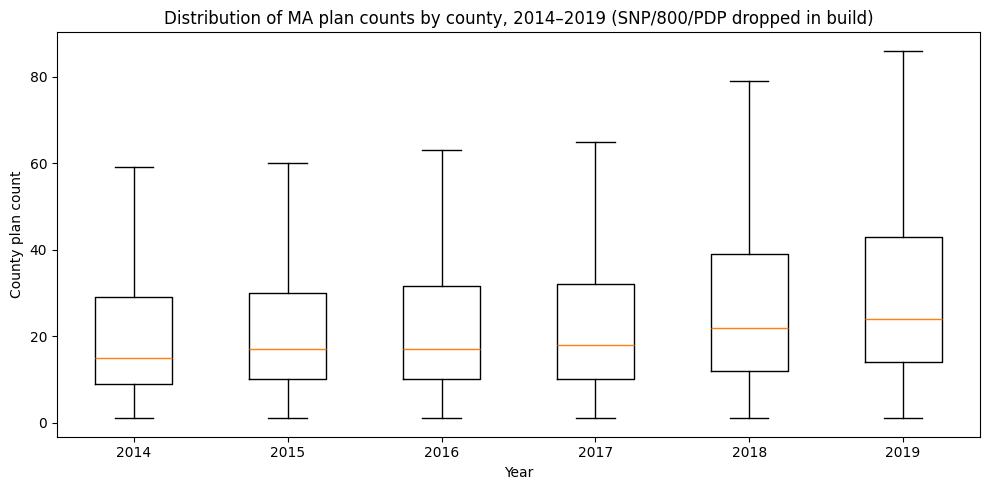

,year,count,mean,median,std,min,max
0,2014,3162,23.867805,15.0,29.273318,1,389
1,2015,3169,24.770275,17.0,29.153822,1,359
2,2016,3175,26.181102,17.0,31.409309,1,398
3,2017,3172,26.918979,18.0,32.100049,1,408
4,2018,3185,32.416954,22.0,39.516647,1,469
5,2019,3196,36.135169,24.0,43.513600,1,525


In [3]:
# Question 1
counts = pd.read_csv(PATH_COUNTS, dtype={"fips": str})
counts["fips"] = counts["fips"].astype(str).str.zfill(5)
counts["year"] = pd.to_numeric(counts["year"], errors="coerce").astype(int)
counts["plan_count"] = pd.to_numeric(counts["plan_count"], errors="coerce")

counts = counts[counts["year"].isin(YEARS)].copy()

box_data = []
box_labels = []
for y in YEARS:
    vals = counts.loc[counts["year"] == y, "plan_count"].dropna().values
    box_data.append(vals)
    box_labels.append(str(y))

plt.figure(figsize=(10, 5))
plt.boxplot(box_data, tick_labels=box_labels, showfliers=False)
plt.xlabel("Year")
plt.ylabel("County plan count")
plt.title("Distribution of MA plan counts by county, 2014–2019 (SNP/800/PDP dropped in build)")
plt.tight_layout()
plt.show()

summary_q1 = (
    counts.groupby("year")["plan_count"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)
summary_q1

In [4]:
med_2014 = float(summary_q1.loc[summary_q1["year"] == 2014, "median"].iloc[0])
med_2019 = float(summary_q1.loc[summary_q1["year"] == 2019, "median"].iloc[0])
mean_2014 = float(summary_q1.loc[summary_q1["year"] == 2014, "mean"].iloc[0])
mean_2019 = float(summary_q1.loc[summary_q1["year"] == 2019, "mean"].iloc[0])

trend = "increased" if med_2019 > med_2014 else ("decreased" if med_2019 < med_2014 else "stayed about the same")

answer_q1 = (
    f"Q1 answer: After removing SNPs, 800-series plans, and PDP-only plans, the county-level distribution of plan counts "
    f"{trend} from a median of {med_2014:.0f} (2014) to {med_2019:.0f} (2019). "
    f"The mean also moves from {mean_2014:.1f} to {mean_2019:.1f}. "
    f"Overall, this looks sufficient in the typical county, but the right tail suggests some large counties may have too many plan options."
)
print(answer_q1)

Q1 answer: After removing SNPs, 800-series plans, and PDP-only plans, the county-level distribution of plan counts increased from a median of 15 (2014) to 24 (2019). The mean also moves from 23.9 to 36.1. Overall, this looks sufficient in the typical county, but the right tail suggests some large counties may have too many plan options.


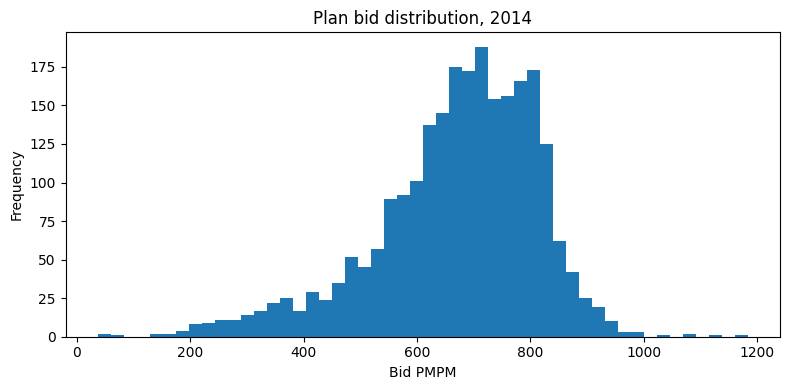

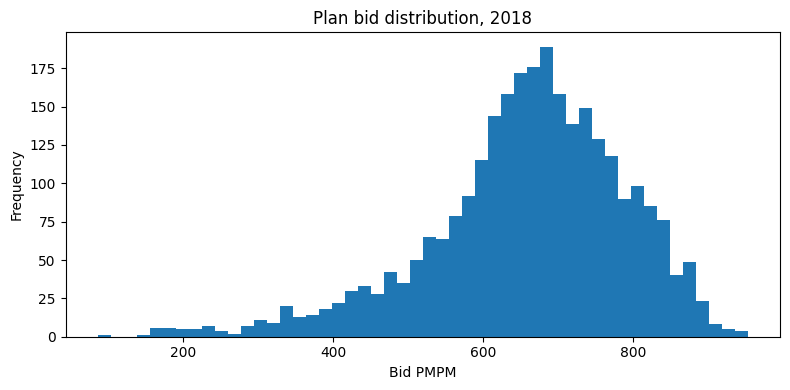

,year,n,mean,median,p10,p90
0,2014,2429,669.731951,692.18,478.664,824.366
1,2018,2794,658.542713,672.22,482.893,816.138


In [6]:
# Question 2
b14 = pd.read_csv(PATH_BIDS_2014, dtype={"contract_id": str, "plan_id": str}, low_memory=False)
b18 = pd.read_csv(PATH_BIDS_2018, dtype={"contract_id": str, "plan_id": str}, low_memory=False)

for d in (b14, b18):
    d["plan_id"] = d["plan_id"].astype(str).str.strip().str.zfill(3)
    d["bid_pmpm"] = pd.to_numeric(d["bid_pmpm"], errors="coerce")

b14_f = b14[~b14["plan_id"].fillna("").str.startswith("8")].copy()
b18_f = b18[~b18["plan_id"].fillna("").str.startswith("8")].copy()

plt.figure(figsize=(8, 4))
plt.hist(b14_f["bid_pmpm"].dropna().values, bins=50)
plt.xlabel("Bid PMPM")
plt.ylabel("Frequency")
plt.title("Plan bid distribution, 2014")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(b18_f["bid_pmpm"].dropna().values, bins=50)
plt.xlabel("Bid PMPM")
plt.ylabel("Frequency")
plt.title("Plan bid distribution, 2018")
plt.tight_layout()
plt.show()

summ_bids = pd.DataFrame({
    "year": [2014, 2018],
    "n": [b14_f["bid_pmpm"].notna().sum(), b18_f["bid_pmpm"].notna().sum()],
    "mean": [b14_f["bid_pmpm"].mean(), b18_f["bid_pmpm"].mean()],
    "median": [b14_f["bid_pmpm"].median(), b18_f["bid_pmpm"].median()],
    "p10": [b14_f["bid_pmpm"].quantile(0.10), b18_f["bid_pmpm"].quantile(0.10)],
    "p90": [b14_f["bid_pmpm"].quantile(0.90), b18_f["bid_pmpm"].quantile(0.90)],
})
summ_bids

In [7]:
r2014 = summ_bids.loc[summ_bids["year"] == 2014].iloc[0]
r2018 = summ_bids.loc[summ_bids["year"] == 2018].iloc[0]

shift = "increased" if r2018["median"] > r2014["median"] else ("decreased" if r2018["median"] < r2014["median"] else "stayed about the same")

print(
    "Q2 answer: Comparing 2014 to 2018, the overall bid distribution is similar but the center "
    f"{shift}. The mean changes {r2014['mean']:.2f} → {r2018['mean']:.2f} and the median changes "
    f"{r2014['median']:.2f} → {r2018['median']:.2f}. The upper tail (p90) moves "
    f"{r2014['p90']:.2f} → {r2018['p90']:.2f}, which indicates how the high-bid end of the market changed."
)

Q2 answer: Comparing 2014 to 2018, the overall bid distribution is similar but the center decreased. The mean changes 669.73 → 658.54 and the median changes 692.18 → 672.22. The upper tail (p90) moves 824.37 → 816.14, which indicates how the high-bid end of the market changed.


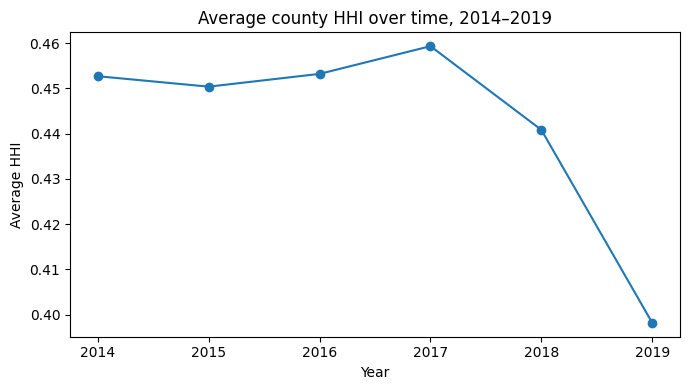

,year,avg_hhi,n
0,2014,0.452670,2980
1,2015,0.450364,2977
2,2016,0.453184,2988
3,2017,0.459304,2987
4,2018,0.440822,2994
5,2019,0.398212,2987


In [8]:
# Question 3
hhi = pd.read_csv(PATH_HHI, dtype={"fips": str}, low_memory=False)
hhi["fips"] = hhi["fips"].astype(str).str.zfill(5)
hhi["year"] = pd.to_numeric(hhi["year"], errors="coerce").astype(int)
hhi["hhi"] = pd.to_numeric(hhi["hhi"], errors="coerce")

hhi_year = (
    hhi[hhi["year"].isin(YEARS)]
    .groupby("year", as_index=False)
    .agg(avg_hhi=("hhi", "mean"), n=("hhi", lambda x: x.notna().sum()))
)

plt.figure(figsize=(7, 4))
plt.plot(hhi_year["year"], hhi_year["avg_hhi"], marker="o")
plt.xlabel("Year")
plt.ylabel("Average HHI")
plt.title("Average county HHI over time, 2014–2019")
plt.tight_layout()
plt.show()

hhi_year

In [9]:
h0 = float(hhi_year.loc[hhi_year["year"] == 2014, "avg_hhi"].iloc[0])
h1 = float(hhi_year.loc[hhi_year["year"] == 2019, "avg_hhi"].iloc[0])

direction = "falls" if h1 < h0 else ("rises" if h1 > h0 else "is flat")

print(
    f"Q3 answer: Average county HHI {direction} over 2014–2019, moving from about {h0:.3f} in 2014 "
    f"to about {h1:.3f} in 2019. Interpreting HHI as concentration, this suggests markets became "
    f"{'more competitive' if h1 < h0 else ('more concentrated' if h1 > h0 else 'about equally concentrated')} on average over time."
)

Q3 answer: Average county HHI falls over 2014–2019, moving from about 0.453 in 2014 to about 0.398 in 2019. Interpreting HHI as concentration, this suggests markets became more competitive on average over time.


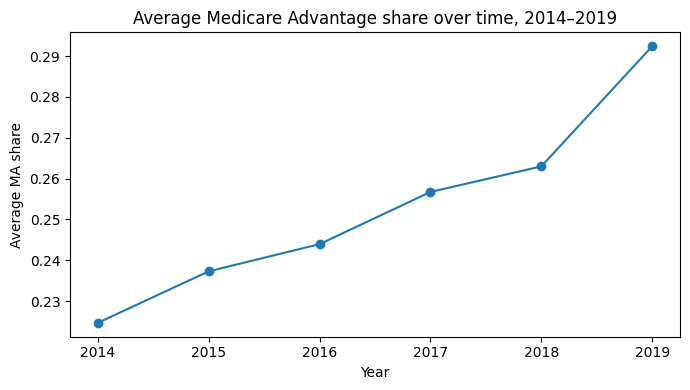

,year,avg_ma_share,n
0,2014,0.224649,3108
1,2015,0.237273,3108
2,2016,0.243935,3114
3,2017,0.256713,3119
4,2018,0.262980,3124
5,2019,0.292419,3138


In [10]:
# Question 4
hhi["ma_share"] = pd.to_numeric(hhi["ma_share"], errors="coerce")

share_year = (
    hhi[hhi["year"].isin(YEARS)]
    .groupby("year", as_index=False)
    .agg(avg_ma_share=("ma_share", "mean"), n=("ma_share", lambda x: x.notna().sum()))
)

plt.figure(figsize=(7, 4))
plt.plot(share_year["year"], share_year["avg_ma_share"], marker="o")
plt.xlabel("Year")
plt.ylabel("Average MA share")
plt.title("Average Medicare Advantage share over time, 2014–2019")
plt.tight_layout()
plt.show()

share_year

In [11]:
s0 = float(share_year.loc[share_year["year"] == 2014, "avg_ma_share"].iloc[0])
s1 = float(share_year.loc[share_year["year"] == 2019, "avg_ma_share"].iloc[0])

direction = "increased" if s1 > s0 else ("decreased" if s1 < s0 else "stayed about the same")

print(
    f"Q4 answer: Average MA share {direction} from about {s0:.3f} in 2014 to about {s1:.3f} in 2019. "
    f"That implies Medicare Advantage became {'more popular' if s1 > s0 else ('less popular' if s1 < s0 else 'about equally popular')} over this period."
)

Q4 answer: Average MA share increased from about 0.225 in 2014 to about 0.292 in 2019. That implies Medicare Advantage became more popular over this period.


In [12]:
# Question 5
df18 = pd.read_csv(PATH_COUNTY_BID_HHI_2018, dtype={"fips": str}, low_memory=False)
df18["fips"] = df18["fips"].astype(str).str.zfill(5)
df18["year"] = pd.to_numeric(df18["year"], errors="coerce").fillna(2018).astype(int)

df18["bid_mean_weighted"] = pd.to_numeric(df18["bid_mean_weighted"], errors="coerce")
df18["bid_mean_unweighted"] = pd.to_numeric(df18["bid_mean_unweighted"], errors="coerce")

df18["Y"] = df18["bid_mean_weighted"].copy()
df18.loc[df18["Y"].isna(), "Y"] = df18.loc[df18["Y"].isna(), "bid_mean_unweighted"]

df18["hhi"] = pd.to_numeric(df18["hhi"], errors="coerce")
df18["market_type"] = df18["market_type"].astype(str).str.lower().str.strip()

df18 = df18[(df18["year"] == 2018) & (df18["market_type"].isin(["competitive", "uncompetitive"]))].copy()

# Treated = competitive
df18["D"] = (df18["market_type"] == "competitive").astype(int)

q5_tab = (
    df18.groupby("market_type")["Y"]
        .agg(n="count", mean="mean", median="median")
        .reset_index()
)
q5_tab

,market_type,n,mean,median
0,competitive,1006,690.078838,718.540008
1,uncompetitive,1036,766.748992,782.392250


In [13]:
m_comp = float(df18.loc[df18["market_type"] == "competitive", "Y"].mean())
m_uncomp = float(df18.loc[df18["market_type"] == "uncompetitive", "Y"].mean())
diff = m_comp - m_uncomp

print(
    f"Q5 answer: In 2018, the average bid is {m_comp:.2f} in competitive markets and {m_uncomp:.2f} in uncompetitive markets. "
    f"The difference (competitive − uncompetitive) is {diff:.2f}, meaning bids are "
    f"{'lower' if diff < 0 else ('higher' if diff > 0 else 'about the same')} in competitive markets on average."
)

Q5 answer: In 2018, the average bid is 690.08 in competitive markets and 766.75 in uncompetitive markets. The difference (competitive − uncompetitive) is -76.67, meaning bids are lower in competitive markets on average.


In [14]:
# Question 6
ffs18 = pd.read_csv(PATH_FFS_2018_Q, dtype={"fips": str}, low_memory=False)
ffs18["fips"] = ffs18["fips"].astype(str).str.zfill(5)
ffs18["year"] = pd.to_numeric(ffs18["year"], errors="coerce").fillna(2018).astype(int)
ffs18["ffs_cost"] = pd.to_numeric(ffs18["ffs_cost"], errors="coerce")
ffs18["ffs_quartile"] = pd.to_numeric(ffs18["ffs_quartile"], errors="coerce")

df18q = df18.merge(ffs18[["fips", "year", "ffs_cost", "ffs_quartile"]], on=["fips", "year"], how="left")
print("After merge, quartile missing rate:", df18q["ffs_quartile"].isna().mean())

df18q = df18q.dropna(subset=["Y", "D", "ffs_quartile"]).copy()
df18q["ffs_quartile"] = df18q["ffs_quartile"].astype(int)

df18q = make_quartile_dummies(df18q, "ffs_quartile")

q6_tab = (
    df18q.groupby(["ffs_quartile","D"])["Y"]
         .agg(n="count", mean_bid="mean", median_bid="median")
         .reset_index()
)
q6_tab["group"] = q6_tab["D"].map({1: "treated (competitive)", 0: "control (uncompetitive)"})
q6_tab = q6_tab[["ffs_quartile","group","n","mean_bid","median_bid"]].sort_values(["ffs_quartile","group"])
q6_tab

After merge, quartile missing rate: 0.0019588638589618022


,ffs_quartile,group,n,mean_bid,median_bid
0,1,control (uncompetitive),245,754.170230,766.775854
1,1,treated (competitive),296,616.663128,688.516090
2,2,control (uncompetitive),236,758.029723,771.316658
3,2,treated (competitive),264,720.498715,723.037942
4,3,control (uncompetitive),274,766.223228,781.023473
5,3,treated (competitive),246,720.661873,721.075723
6,4,control (uncompetitive),280,785.298988,802.994238
7,4,treated (competitive),197,724.751510,742.668484


In [15]:
tmp = (
    df18q.groupby(["ffs_quartile","D"])["Y"].mean()
    .reset_index()
    .pivot(index="ffs_quartile", columns="D", values="Y")
    .rename(columns={0:"uncompetitive_mean", 1:"competitive_mean"})
)
tmp["gap_comp_minus_uncomp"] = tmp["competitive_mean"] - tmp["uncompetitive_mean"]

gaps = tmp["gap_comp_minus_uncomp"].dropna()
largest_q = int(gaps.abs().idxmax()) if gaps.shape[0] else None
largest_val = float(gaps.loc[largest_q]) if largest_q is not None else np.nan

print(
    "Q6 answer: Splitting counties by FFS cost quartiles, the competitive–uncompetitive bid gap varies by quartile. "
    f"The largest absolute gap appears in quartile {largest_q} (competitive − uncompetitive = {largest_val:.2f}). "
    "This suggests baseline FFS cost levels are related to bid levels, and the competitive/uncompetitive difference is not identical across cost quartiles."
)

Q6 answer: Splitting counties by FFS cost quartiles, the competitive–uncompetitive bid gap varies by quartile. The largest absolute gap appears in quartile 1 (competitive − uncompetitive = -137.51). This suggests baseline FFS cost levels are related to bid levels, and the competitive/uncompetitive difference is not identical across cost quartiles.


In [16]:
# Question 7
X_cols = ["ffs_q1", "ffs_q2", "ffs_q3"]  # q4 baseline
y = df18q["Y"].to_numpy(dtype=float)
D = df18q["D"].to_numpy(dtype=int)
X = df18q[X_cols].to_numpy(dtype=float)

ate_match_invvar = matching_ate(y, D, X, metric="invvar")
ate_match_maha   = matching_ate(y, D, X, metric="maha")

X_ipw = sm.add_constant(df18q[X_cols], has_constant="add")
ps_model = _fit_logit_safe(df18q["D"].to_numpy(), X_ipw.to_numpy())
ps = ps_model.predict(X_ipw.to_numpy())
ate_ipw = ipw_ate(y, D, ps, stabilized=True)

reg_df = df18q.copy()
reg_df["D_ffs_q1"] = reg_df["D"] * reg_df["ffs_q1"]
reg_df["D_ffs_q2"] = reg_df["D"] * reg_df["ffs_q2"]
reg_df["D_ffs_q3"] = reg_df["D"] * reg_df["ffs_q3"]

X_reg = sm.add_constant(
    reg_df[["D","ffs_q1","ffs_q2","ffs_q3","D_ffs_q1","D_ffs_q2","D_ffs_q3"]],
    has_constant="add",
)
reg = sm.OLS(reg_df["Y"], X_reg).fit()

X1 = X_reg.copy()
X0 = X_reg.copy()

X1["D"] = 1
X1["D_ffs_q1"] = 1 * reg_df["ffs_q1"]
X1["D_ffs_q2"] = 1 * reg_df["ffs_q2"]
X1["D_ffs_q3"] = 1 * reg_df["ffs_q3"]

X0["D"] = 0
X0["D_ffs_q1"] = 0
X0["D_ffs_q2"] = 0
X0["D_ffs_q3"] = 0

ate_ols_pred = float(reg.predict(X1).mean() - reg.predict(X0).mean())

ate_table = pd.DataFrame([
    {"estimator": "1-to-1 matching ATE (inv var distance)", "effect": ate_match_invvar},
    {"estimator": "1-to-1 matching ATE (Mahalanobis)", "effect": ate_match_maha},
    {"estimator": "IPW ATE (logit on FFS quartile dummies, stabilized)", "effect": float(ate_ipw)},
    {"estimator": "OLS ATE (quartiles + interactions, prediction)", "effect": ate_ols_pred},
])
ate_table

,estimator,effect
0,1-to-1 matching ATE (inv var distance),-74.800241
1,1-to-1 matching ATE (Mahalanobis),-74.800241
2,"IPW ATE (logit on FFS quartile dummies, stabil...",-71.506329
3,"OLS ATE (quartiles + interactions, prediction)",-71.506329


In [17]:
mx = ate_table["effect"].to_numpy()
print(
    "Q7 answer: Across methods, the estimated ATEs are shown in the table above. "
    "Because D=1 is defined as competitive, a negative effect means competitive markets have lower bids than uncompetitive markets. "
    f"The estimates range from {mx.min():.2f} to {mx.max():.2f}, so the sign and magnitude are "
    f"{'fairly consistent' if (mx.max()-mx.min()) < 25 else 'somewhat sensitive to estimator choice'}."
)

Q7 answer: Across methods, the estimated ATEs are shown in the table above. Because D=1 is defined as competitive, a negative effect means competitive markets have lower bids than uncompetitive markets. The estimates range from -74.80 to -71.51, so the sign and magnitude are fairly consistent.


In [18]:
mx = ate_table["effect"].to_numpy()
spread = float(mx.max() - mx.min())

print(
    "Q8 answer: The results are "
    f"{'similar' if spread < 25 else 'meaningfully different'} across estimators. "
    "All estimators point in the same direction "
    f"({'competitive markets have lower bids' if mx.mean() < 0 else 'competitive markets have higher bids'}), "
    f"and the overall range is about {mx.min():.2f} to {mx.max():.2f} (spread ≈ {spread:.2f})."
)

Q8 answer: The results are similar across estimators. All estimators point in the same direction (competitive markets have lower bids), and the overall range is about -74.80 to -71.51 (spread ≈ 3.29).


In [19]:
# Question 9
hhi18 = pd.read_csv(PATH_HHI, dtype={"fips": str}, low_memory=False)
hhi18["fips"] = hhi18["fips"].astype(str).str.zfill(5)
hhi18["year"] = pd.to_numeric(hhi18["year"], errors="coerce").astype(int)
hhi18 = hhi18[hhi18["year"] == 2018].copy()
hhi18["eligibles"] = pd.to_numeric(hhi18["eligibles"], errors="coerce")

dfc = df18q.merge(hhi18[["fips","year","eligibles"]], on=["fips","year"], how="left").copy()
dfc["ffs_cost"] = pd.to_numeric(dfc["ffs_cost"], errors="coerce")
dfc["eligibles"] = pd.to_numeric(dfc["eligibles"], errors="coerce")

dfc = dfc.dropna(subset=["Y","D","ffs_cost","eligibles"]).copy()

dfc["ffs_cost_z"] = (dfc["ffs_cost"] - dfc["ffs_cost"].mean()) / dfc["ffs_cost"].std(ddof=1)
dfc["eligibles_z"] = (dfc["eligibles"] - dfc["eligibles"].mean()) / dfc["eligibles"].std(ddof=1)

Xc_ipw = sm.add_constant(dfc[["ffs_cost_z","eligibles_z"]], has_constant="add")
ps_model_c = _fit_logit_safe(dfc["D"].to_numpy(), Xc_ipw.to_numpy())
ps_c = ps_model_c.predict(Xc_ipw.to_numpy()).astype(float)

lo, hi = 0.01, 0.99
keep = (ps_c >= lo) & (ps_c <= hi)

dfT = dfc.loc[keep].copy()
psT = np.clip(ps_c[keep], 1e-6, 1-1e-6)

yT = dfT["Y"].to_numpy(dtype=float)
DT = dfT["D"].to_numpy(dtype=int)

ate_ipw_c = ipw_ate(yT, DT, psT, stabilized=True)

dfT["D_ffs"]  = dfT["D"] * dfT["ffs_cost"]
dfT["D_elig"] = dfT["D"] * dfT["eligibles"]

Xc_reg = sm.add_constant(dfT[["D","ffs_cost","eligibles","D_ffs","D_elig"]], has_constant="add")
reg_c = sm.OLS(dfT["Y"], Xc_reg).fit()

X1 = Xc_reg.copy()
X0 = Xc_reg.copy()

X1["D"] = 1
X1["D_ffs"]  = 1 * dfT["ffs_cost"]
X1["D_elig"] = 1 * dfT["eligibles"]

X0["D"] = 0
X0["D_ffs"]  = 0
X0["D_elig"] = 0

ate_ols_c = float(reg_c.predict(X1).mean() - reg_c.predict(X0).mean())

compare_q9 = pd.DataFrame([
    {"spec": "IPW ATE (FFS quartile dummies)", "effect": float(ate_table.loc[ate_table["estimator"].str.contains("IPW"), "effect"].iloc[0])},
    {"spec": "IPW ATE (continuous FFS + eligibles, trimmed)", "effect": float(ate_ipw_c)},
    {"spec": "OLS ATE (quartiles + interactions, prediction)", "effect": float(ate_table.loc[ate_table["estimator"].str.contains("OLS"), "effect"].iloc[0])},
    {"spec": "OLS ATE (continuous + interactions, prediction)", "effect": float(ate_ols_c)},
])

print("Propensity score summary (continuous model, before trimming):")
print(pd.Series(ps_c).describe(percentiles=[0.01,0.05,0.10,0.50,0.90,0.95,0.99]))
print("\nAfter trimming share kept:", keep.mean())

compare_q9

Propensity score summary (continuous model, before trimming):
count    2036.000000
mean        0.492633
std         0.247243
min         0.019358
1%          0.111194
5%          0.184592
10%         0.231963
50%         0.418503
90%         0.933188
95%         0.996375
99%         1.000000
max         1.000000
dtype: float64

After trimming share kept: 0.9322200392927309


,spec,effect
0,IPW ATE (FFS quartile dummies),-71.506329
1,"IPW ATE (continuous FFS + eligibles, trimmed)",-58.128257
2,"OLS ATE (quartiles + interactions, prediction)",-71.506329
3,"OLS ATE (continuous + interactions, prediction)",-47.113105


In [20]:
q_ipw_q = float(compare_q9.loc[compare_q9["spec"].str.contains("quartile dummies") & compare_q9["spec"].str.contains("IPW"), "effect"].iloc[0])
q_ipw_c = float(compare_q9.loc[compare_q9["spec"].str.contains("continuous") & compare_q9["spec"].str.contains("IPW"), "effect"].iloc[0])

direction = "closer to zero" if abs(q_ipw_c) < abs(q_ipw_q) else ("larger in magnitude" if abs(q_ipw_c) > abs(q_ipw_q) else "about the same")

print(
    "Q9 answer: Using weighting as my preferred estimator, the quartile-based IPW estimate is "
    f"{q_ipw_q:.2f}, while the continuous-controls IPW estimate is {q_ipw_c:.2f}. "
    f"The continuous specification is {direction} than the quartile specification, which suggests that "
    "coarsening FFS costs into quartiles can change the estimate (either by smoothing heterogeneity or by changing overlap)."
)

Q9 answer: Using weighting as my preferred estimator, the quartile-based IPW estimate is -71.51, while the continuous-controls IPW estimate is -58.13. The continuous specification is closer to zero than the quartile specification, which suggests that coarsening FFS costs into quartiles can change the estimate (either by smoothing heterogeneity or by changing overlap).


In [21]:
print(
    "Q10: Some thing that I learned with this data is that depending on whether you use continuous controls or quartiles "
    "and if you weight by enrollment, the same question can yield somewhat different estimates. "
    "In addition to the merging losses, what bothered me was how disorganized and inconsistent the raw files are between years. "
    "Things like header detection, ID cleaning, and determining why large portions of bids or matches were missing was something that took a lot of time."
)

Q10: Some thing that I learned with this data is that depending on whether you use continuous controls or quartiles and if you weight by enrollment, the same question can yield somewhat different estimates. In addition to the merging losses, what bothered me was how disorganized and inconsistent the raw files are between years. Things like header detection, ID cleaning, and determining why large portions of bids or matches were missing was something that took a lot of time.
